In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report



import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.regularizers import l2,l1
# tf.compat.v1.disable_eager_execution()
import warnings



# Train Data

In [3]:
train_df=pd.read_csv("data/clean_data/train_clean.csv").drop('Unnamed: 0',axis=1)

In [4]:
train_df.head()

,rec_id,text,sentiment,rating,clean_text
0,4715,For a movie that gets no respect there sure ar...,pos,9,movie get respect sure lot memorable quote lis...
1,12390,Bizarre horror movie filled with famous faces ...,pos,8,bizarre horror movie fill famous face steal cr...
2,8329,"A solid, if unremarkable film. Matthau, as Ein...",pos,7,solid remarkable film matthau einstein wonderf...
3,9063,It's a strange feeling to sit alone in a theat...,pos,8,strange feeling sit alone theater occupy paren...
4,3092,"You probably all already know this by now, but...",pos,10,probably already know additional episode never...


In [5]:
# train_df.columns
# df_pos = train_df[train_df['sentiment'] == 'pos']
# df_neg = train_df[train_df['sentiment'] == 'neg']
# num_samples = min(len(df_pos), len(df_neg))

# df_pos = df_pos.sample(frac=1).reset_index(drop=True)
# df_neg = df_neg.sample(frac=1).reset_index(drop=True)

# reshuffled_df = pd.DataFrame(columns=['rec_id', 'text', 'sentiment', 'rating', 'clean_text'])

# for i in range(num_samples):
#     reshuffled_df = pd.concat([reshuffled_df, pd.DataFrame([df_pos.iloc[i]])])
#     reshuffled_df = pd.concat([reshuffled_df, pd.DataFrame([df_neg.iloc[i]])])

# reshuffled_df = reshuffled_df.reset_index(drop=True)

# train_df=reshuffled_df

In [6]:
train_df['sentiment'].value_counts()

pos    12500
neg    12500
Name: sentiment, dtype: int64

In [7]:
train_df['rating'].value_counts()

1     5100
10    4732
8     3009
4     2696
7     2496
3     2420
2     2284
9     2263
Name: rating, dtype: int64

# Choose num_words in tokenizer and maxlen of padded_sequences

### on raw data

In [8]:
# Seeing unique words in raw data just to understand how many words are removed due to stop words & lemmatisation
texts = train_df['text'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [9]:
vocab_size = len(tokenizer.word_index)

In [10]:
print(f"Total unique words in raw dataset: {vocab_size}")

Total unique words in raw dataset: 88582


### on clean data

In [11]:
texts = train_df['clean_text'].tolist()
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

In [12]:
vocab_size = len(tokenizer.word_index)

In [13]:
print(f"Total unique words in clean dataset: {vocab_size}")

Total unique words in clean dataset: 41567


In [14]:
word_counts = tokenizer.word_counts
word_count_list = list(word_counts.values())

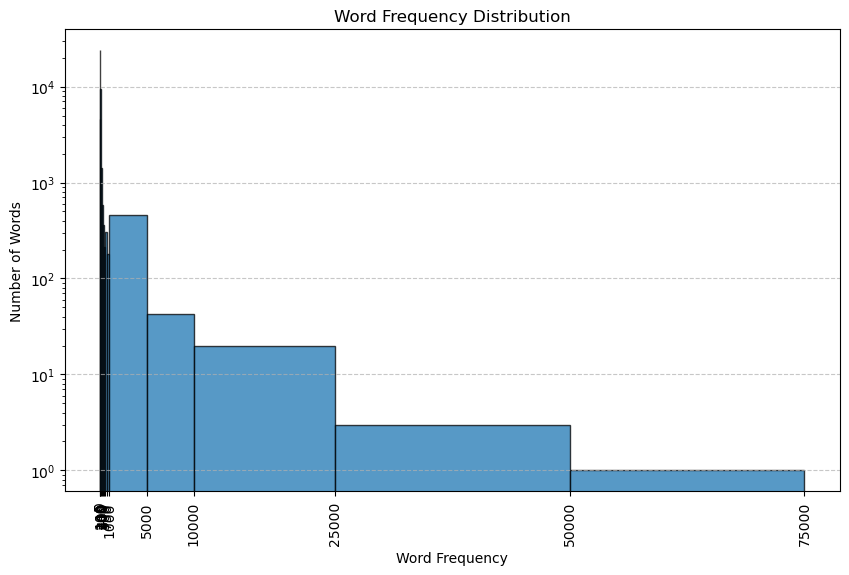

Bin Edges: [0.0e+00 5.0e+00 1.0e+01 1.0e+02 2.0e+02 3.0e+02 4.0e+02 5.0e+02 7.5e+02
 1.0e+03 5.0e+03 1.0e+04 2.5e+04 5.0e+04 7.5e+04]
Values: [2.3896e+04 4.5820e+03 9.4880e+03 1.4290e+03 5.8500e+02 3.6400e+02
 2.1400e+02 3.0800e+02 1.7800e+02 4.5600e+02 4.3000e+01 2.0000e+01
 3.0000e+00 1.0000e+00]


In [15]:
plt.figure(figsize=(10, 6))
hist, bin_edges, _ = plt.hist(word_count_list,bins=[0,5,10,100,200,300,400,500,750,1000,5000,10000,25000,50000,75000], edgecolor='k', alpha=0.75)
plt.xticks([0,5,10,100,200,300,400,500,750,1000,5000,10000,25000,50000,75000],rotation=90)
plt.yscale('log')
plt.title('Word Frequency Distribution')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Bin Edges:", bin_edges)
print("Values:", hist)

In [16]:
pd.DataFrame(word_count_list).describe()

,0
count,41567.000000
mean,72.410229
std,674.744562
min,1.000000
25%,1.000000
50%,3.000000
75%,16.000000
max,66008.000000


In [17]:
# so if we consider num_words to be around 20K; to get all the words which have frequency greater than 5.

In [18]:
sequence_lengths = [len(text.split()) for text in texts]

In [19]:
pd.DataFrame(sequence_lengths).describe()

,0
count,25000.00000
mean,120.39504
std,90.83617
min,4.00000
25%,64.00000
50%,89.00000
75%,147.00000
max,1403.00000


<Axes: ylabel='Density'>

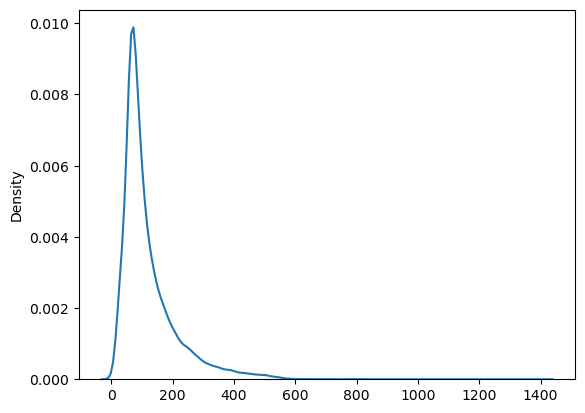

In [20]:
sns.kdeplot(sequence_lengths)

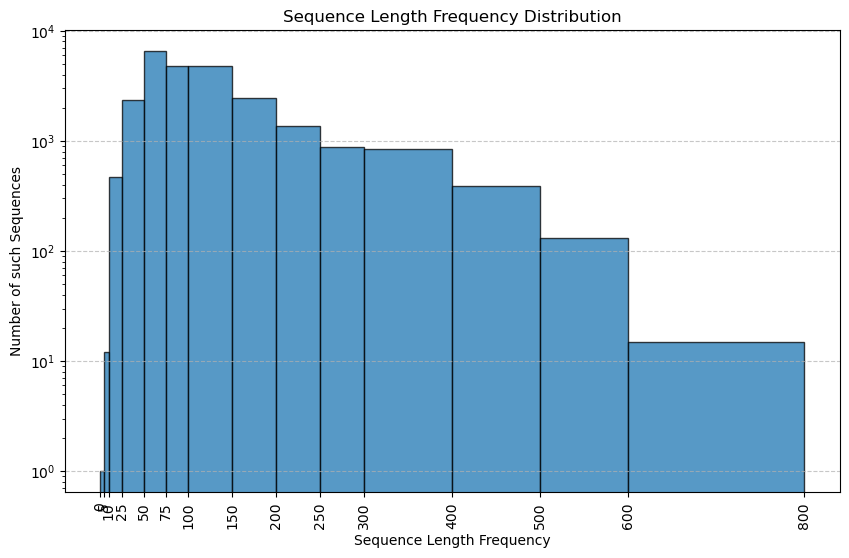

Bin Edges: [  0.   5.  10.  25.  50.  75. 100. 150. 200. 250. 300. 400. 500. 600.
 800.]
Values: [1.000e+00 1.200e+01 4.730e+02 2.339e+03 6.543e+03 4.833e+03 4.743e+03
 2.442e+03 1.362e+03 8.720e+02 8.410e+02 3.880e+02 1.310e+02 1.500e+01]


In [21]:
plt.figure(figsize=(10, 6))
hist, bin_edges, _ = plt.hist(sequence_lengths,bins=[0,5,10,25,50,75,100,150,200,250,300,400,500,600,800], edgecolor='k', alpha=0.75)
plt.xticks([0,5,10,25,50,75,100,150,200,250,300,400,500,600,800],rotation=90)
plt.yscale('log')
plt.title('Sequence Length Frequency Distribution')
plt.xlabel('Sequence Length Frequency')
plt.ylabel('Number of such Sequences')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
print("Bin Edges:", bin_edges)
print("Values:", hist)

In [22]:
# As there are only ~5K with sentences with length greater than 250; 
# we can select with maxlen between of 0 and 250;

# Training and Testing

In [23]:
'''Hyper parameters here are
1. Tokenizer(num_words)
2. max_len of sequences for padding and truncating
3. Model Architecture
4. optimizer
5. Learning rate
6. Batch Size

'''

'Hyper parameters here are\n1. Tokenizer(num_words)\n2. max_len of sequences for padding and truncating\n3. Model Architecture\n4. optimizer\n5. Learning rate\n6. Batch Size\n\n'

In [24]:
test_df=pd.read_csv("data/clean_data/test_clean.csv")

In [25]:
class custom_RNN:
    def __init__(self,train_df,test_df,tokenizer_func,max_len,optimizer,num_words=5000,batch_size=32):
        self.train_df=train_df
        self.test_df=test_df
        self.tokenizer_func=tokenizer_func
        self.num_words=num_words
        self.max_len=max_len
        self.optimizer=optimizer
        self.batch_size=batch_size
    
    def get_sequences(self,data,is_train=False):
        if(is_train):
            tokenizer = self.tokenizer_func(num_words=self.num_words, oov_token='<OOV>')
            tokenizer.fit_on_texts(data)
            self.tokenizer=tokenizer
        sequences = self.tokenizer.texts_to_sequences(data)
        padded_sequences = np.array(pad_sequences(sequences, maxlen=self.max_len, padding='post', truncating='post'))
        
        return padded_sequences
    
    
    def train(self,model_type,epochs=10,is_raw=False):
        
        if(model_type=='s'):
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=128, input_length=self.max_len),
            tf.keras.layers.SimpleRNN(64, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(32, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.2),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        elif(model_type=='m'):
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=384, input_length=self.max_len),
            tf.keras.layers.SimpleRNN(256, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        
        elif(model_type=='l'):
            model = tf.keras.Sequential([
            tf.keras.layers.Embedding(input_dim=self.num_words, output_dim=768, input_length=self.max_len),
            tf.keras.layers.SimpleRNN(384, return_sequences=True),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dense(128, activation="relu"),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(1, activation='sigmoid')
            
        ])
            
         
        
        else:
            print("please enter a valid model type s/m/l; choose one")
            return
        
        self.is_raw=is_raw
        
        if(is_raw):
            train_sequences=self.get_sequences(self.train_df['text'].tolist(),is_train=True)
        else:
            train_sequences=self.get_sequences(self.train_df['clean_text'].tolist(),is_train=True)
        
            
        
        y_train=np.array(self.train_df['sentiment'].map({'pos':1,'neg':0}).tolist())
        
        
        combined_data = list(zip(train_sequences, y_train))
        
        np.random.seed(12)
        
        np.random.shuffle(combined_data)
        
        train_sequences, y_train = zip(*combined_data)
        
        train_sequences=np.array(train_sequences)
        
        y_train=np.array(y_train)
        
        
        num_validation_samples = int(0.20 * len(train_sequences))
        
        x_train = train_sequences[:-num_validation_samples]
        y_train = y_train[:-num_validation_samples]
        x_val = train_sequences[-num_validation_samples:]
        y_val = y_train[-num_validation_samples:]
        
        
        early_stopping_acc= EarlyStopping(monitor='val_accuracy', patience=2, verbose=1,start_from_epoch=5,restore_best_weights=True)
        
        early_stopping_loss= EarlyStopping(monitor='val_loss', patience=2, verbose=1,start_from_epoch=5,restore_best_weights=True)
        
        model.compile(loss='binary_crossentropy', optimizer=self.optimizer, metrics=['accuracy'])
        
        history=model.fit(x_train, y_train, epochs=epochs, batch_size=self.batch_size, validation_data=(x_val, y_val),shuffle=False,callbacks=[early_stopping_acc,early_stopping_loss])
        
        
        
        if early_stopping_acc.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stopping_acc.stopped_epoch + 1}, based on the validation accuracy.')
        if early_stopping_loss.stopped_epoch > 0:
            print(f'Early stopping occurred at epoch {early_stopping_loss.stopped_epoch + 1}, based on the validation loss.')
        
        self.model=model
        
        self.training_accuracy = history.history['accuracy']
        self.validation_accuracy = history.history['val_accuracy']
        
        self.training_loss = history.history['loss']
        self.validation_loss = history.history['val_loss']
        
        
        
        model.save('data/LSTM_models/model_type_'+str(model_type)+'_'+'epochs_'+
              str(epochs)+'_'+str(self.num_words)+'_'+str(self.max_len)+'_'+str('adam')+'_'+str(is_raw))
        
        
        
    def evaluate(self):
        
        if(self.is_raw):
            test_sequences=self.get_sequences(self.test_df['text'].tolist(),is_train=False)
        else:
            test_sequences=self.get_sequences(self.test_df['clean_text'].tolist(),is_train=False)
        
        y_test=np.array(self.test_df['sentiment'].map({'pos':1,'neg':0}).tolist())
        
        predictions = self.model.predict(test_sequences)
        
        binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]
        
        accuracy_rnn = accuracy_score(y_test, binary_predictions)
        
        print("Accuracy (RNN):", accuracy_rnn)
        
        
        confusion_matrix_rnn = confusion_matrix(y_test, binary_predictions)
        
        print("Confusion Matrix (RNN):\n", confusion_matrix_rnn)
        
        
        classification_report_rnn = classification_report(y_test, binary_predictions)
        
        print("Classification Report (RNN):\n", classification_report_rnn)
        
        
        
        
        

# smaller Model

In [26]:
#choose hyper parameters with less num_words and max_len

In [27]:
# num_words=500,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=500,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

Epoch 1/100
40/40 [==============================] - 14s 290ms/step - loss: 0.5545 - accuracy: 0.7156 - val_loss: 0.7024 - val_accuracy: 0.4932
Epoch 2/100
40/40 [==============================] - 10s 239ms/step - loss: 0.4147 - accuracy: 0.8177 - val_loss: 0.7191 - val_accuracy: 0.4972
Epoch 3/100
40/40 [==============================] - 8s 196ms/step - loss: 0.3931 - accuracy: 0.8317 - val_loss: 0.7280 - val_accuracy: 0.4874
Epoch 4/100
40/40 [==============================] - 8s 194ms/step - loss: 0.3835 - accuracy: 0.8349 - val_loss: 0.8241 - val_accuracy: 0.4972
Epoch 5/100
40/40 [==============================] - 8s 193ms/step - loss: 0.3762 - accuracy: 0.8383 - val_loss: 0.7942 - val_accuracy: 0.4880
Epoch 6/100
40/40 [==============================] - 8s 197ms/step - loss: 0.3681 - accuracy: 0.8413 - val_loss: 0.9169 - val_accuracy: 0.4946
Epoch 7/100
40/40 [==============================] - 8s 191ms/step - loss: 0.3605 - accuracy: 0.8470 - val_loss: 0.8935 - val_accuracy: 0.49

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_500_150_adam_False\assets


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 150, 128)          64000     
                                                                 
 simple_rnn (SimpleRNN)      (None, 150, 64)           12352     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 batch_normalization (Batch  (None, 32)                128       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 32)                0

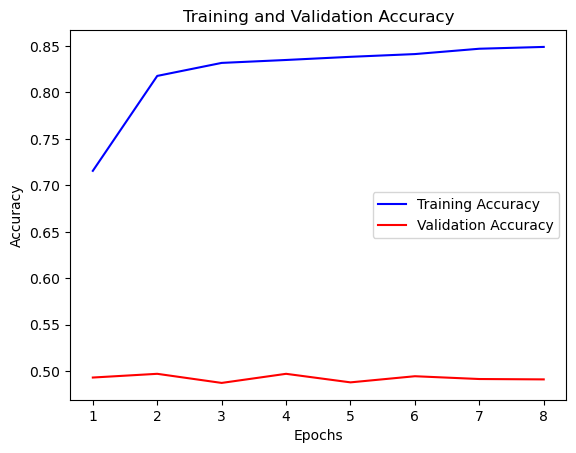

In [28]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

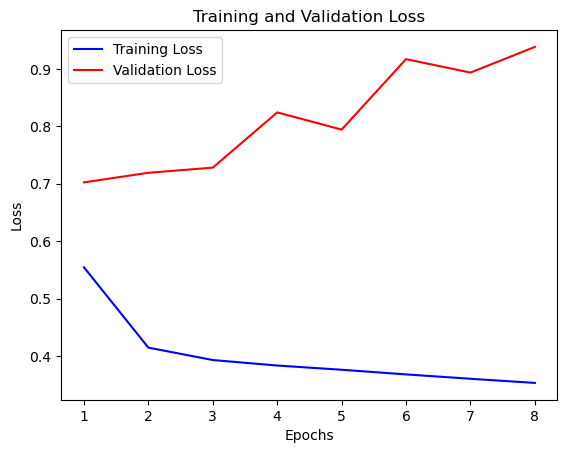

In [29]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [30]:
# num_words=750,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=750,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 9s 199ms/step - loss: 0.4921 - accuracy: 0.7562 - val_loss: 0.7531 - val_accuracy: 0.5016
Epoch 2/100
40/40 [==============================] - 8s 191ms/step - loss: 0.3705 - accuracy: 0.8418 - val_loss: 0.7690 - val_accuracy: 0.4990
Epoch 3/100
40/40 [==============================] - 8s 194ms/step - loss: 0.3547 - accuracy: 0.8519 - val_loss: 0.9260 - val_accuracy: 0.4946
Epoch 4/100
40/40 [==============================] - 8s 194ms/step - loss: 0.3425 - accuracy: 0.8558 - val_loss: 0.8850 - val_accuracy: 0.4902
Epoch 5/100
40/40 [==============================] - 8s 212ms/step - loss: 0.3286 - accuracy: 0.8588 - val_loss: 0.9545 - val_accuracy: 0.4976
Epoch 6/100
40/40 [==============================] - 9s 223ms/step - loss: 0.3225 - accuracy: 0.8652 - val_loss: 1.1499 - val_accuracy: 0.4974
Epoch 7/100
40/40 [==============================] - 9s 221ms/step - loss: 0.3092 - accuracy: 0.8712 - val_loss: 1.1669 - val_accuracy: 0.4944

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_750_150_adam_False\assets


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 150, 128)          96000     
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 150, 64)           12352     
                                                                 
 global_average_pooling1d_1  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_1 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 32)               

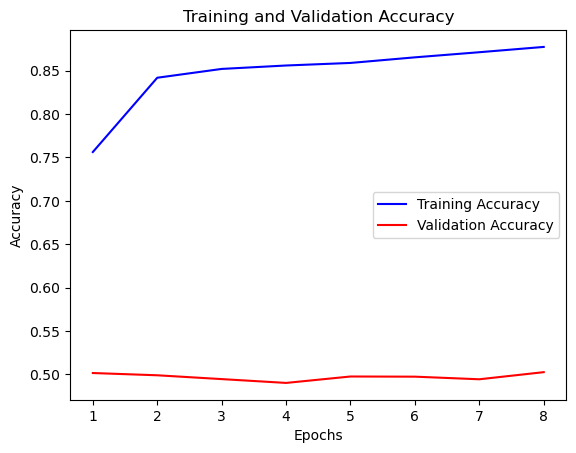

In [31]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

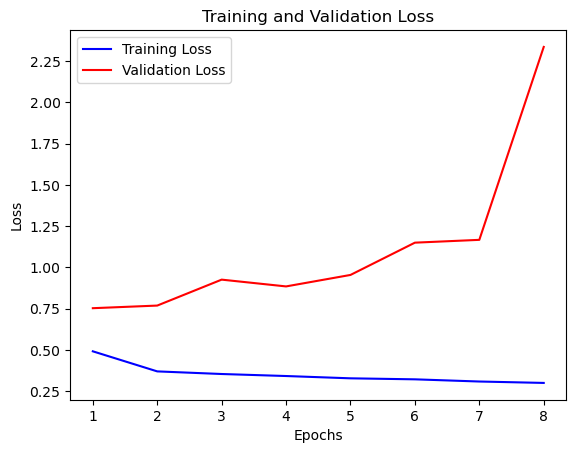

In [32]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [33]:
# num_words=1000,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=1000,batch_size=512)
trainer.train('s',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 10s 224ms/step - loss: 0.5725 - accuracy: 0.6907 - val_loss: 0.9275 - val_accuracy: 0.4974
Epoch 2/100
40/40 [==============================] - 8s 199ms/step - loss: 0.3701 - accuracy: 0.8406 - val_loss: 0.7707 - val_accuracy: 0.4996
Epoch 3/100
40/40 [==============================] - 8s 191ms/step - loss: 0.3447 - accuracy: 0.8553 - val_loss: 0.7964 - val_accuracy: 0.4966
Epoch 4/100
40/40 [==============================] - 8s 200ms/step - loss: 0.3317 - accuracy: 0.8598 - val_loss: 0.8699 - val_accuracy: 0.4964
Epoch 5/100
40/40 [==============================] - 8s 205ms/step - loss: 0.3310 - accuracy: 0.8592 - val_loss: 0.9675 - val_accuracy: 0.4994
Epoch 6/100
40/40 [==============================] - 8s 209ms/step - loss: 0.3200 - accuracy: 0.8676 - val_loss: 0.8801 - val_accuracy: 0.5048
Epoch 7/100
40/40 [==============================] - 9s 228ms/step - loss: 0.2897 - accuracy: 0.8776 - val_loss: 1.1920 - val_accuracy: 0.495

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_s_epochs_100_1000_150_adam_False\assets


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 128)          128000    
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 150, 64)           12352     
                                                                 
 global_average_pooling1d_2  (None, 64)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_2 (Dropout)         (None, 32)               

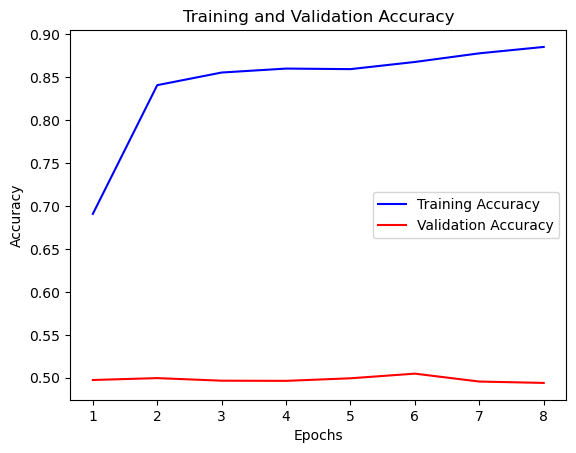

In [34]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

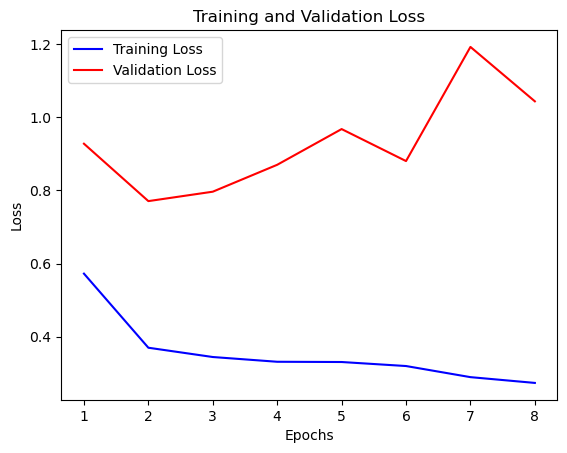

In [35]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [36]:
# num_words=2500,max_len=150, optimizer=adam, learing rate=0.03,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=2500,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 34s 819ms/step - loss: 0.6648 - accuracy: 0.6716 - val_loss: 0.7303 - val_accuracy: 0.5018
Epoch 2/100
40/40 [==============================] - 34s 851ms/step - loss: 0.4810 - accuracy: 0.8109 - val_loss: 1.0182 - val_accuracy: 0.4912
Epoch 3/100
40/40 [==============================] - 39s 972ms/step - loss: 0.4624 - accuracy: 0.8234 - val_loss: 1.1706 - val_accuracy: 0.5016
Epoch 4/100
40/40 [==============================] - 37s 935ms/step - loss: 0.3286 - accuracy: 0.8688 - val_loss: 0.9196 - val_accuracy: 0.5030
Epoch 5/100
40/40 [==============================] - 36s 912ms/step - loss: 0.2828 - accuracy: 0.8858 - val_loss: 0.8921 - val_accuracy: 0.5014
Epoch 6/100
40/40 [==============================] - 35s 868ms/step - loss: 0.2746 - accuracy: 0.8899 - val_loss: 0.9788 - val_accuracy: 0.4988
Epoch 7/100
40/40 [==============================] - 35s 867ms/step - loss: 0.3119 - accuracy: 0.8802 - val_loss: 4.2428 - val_accuracy:

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_2500_150_adam_False\assets


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 150, 384)          960000    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 150, 256)          164096    
                                                                 
 global_average_pooling1d_3  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_3 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 64)               

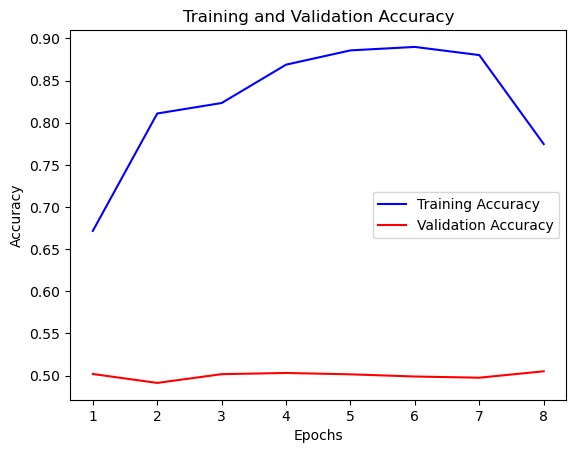

In [37]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

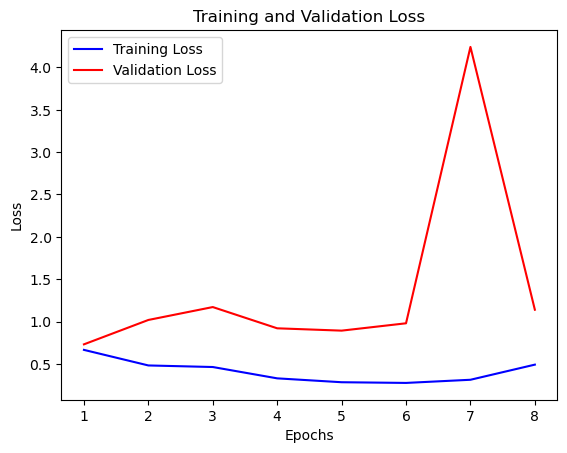

In [38]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [39]:
# num_words=5000,max_len=150, optimizer=adam,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=5000,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 38s 930ms/step - loss: 0.5036 - accuracy: 0.7448 - val_loss: 0.7004 - val_accuracy: 0.4934
Epoch 2/100
40/40 [==============================] - 36s 914ms/step - loss: 0.2701 - accuracy: 0.8909 - val_loss: 0.7143 - val_accuracy: 0.4888
Epoch 3/100
40/40 [==============================] - 39s 980ms/step - loss: 0.2212 - accuracy: 0.9153 - val_loss: 0.7352 - val_accuracy: 0.4944
Epoch 4/100
40/40 [==============================] - 39s 970ms/step - loss: 0.1978 - accuracy: 0.9254 - val_loss: 0.7476 - val_accuracy: 0.4966
Epoch 5/100
40/40 [==============================] - 39s 972ms/step - loss: 0.2091 - accuracy: 0.9197 - val_loss: 0.7446 - val_accuracy: 0.4986
Epoch 6/100
40/40 [==============================] - 38s 964ms/step - loss: 0.1869 - accuracy: 0.9287 - val_loss: 0.8250 - val_accuracy: 0.4936
Epoch 7/100
40/40 [==============================] - 39s 974ms/step - loss: 0.1601 - accuracy: 0.9412 - val_loss: 0.8397 - val_accuracy:

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_5000_150_adam_False\assets


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 150, 384)          1920000   
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 150, 256)          164096    
                                                                 
 global_average_pooling1d_4  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 batch_normalization_4 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_4 (Dropout)         (None, 64)               

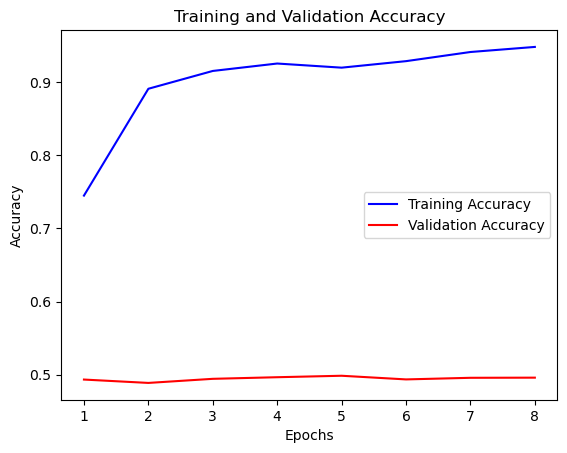

In [40]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

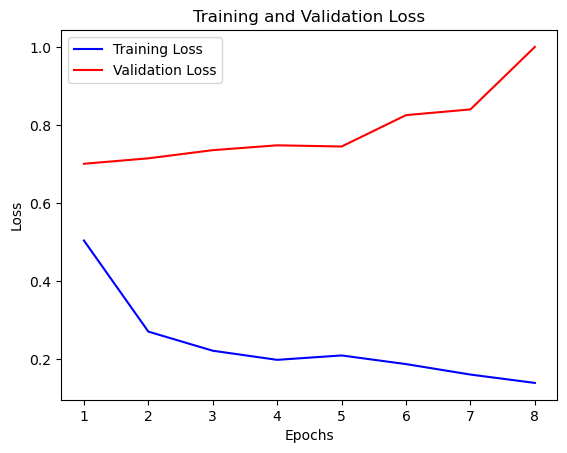

In [41]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [42]:
# num_words=5000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=5000,batch_size=512)
trainer.train('m',100,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 46s 1s/step - loss: 0.5228 - accuracy: 0.7351 - val_loss: 0.6959 - val_accuracy: 0.4920
Epoch 2/100
40/40 [==============================] - 39s 985ms/step - loss: 0.3175 - accuracy: 0.8677 - val_loss: 0.7042 - val_accuracy: 0.4960
Epoch 3/100
40/40 [==============================] - 38s 946ms/step - loss: 0.2689 - accuracy: 0.8923 - val_loss: 0.7209 - val_accuracy: 0.4956
Epoch 4/100
40/40 [==============================] - 42s 1s/step - loss: 0.2415 - accuracy: 0.9064 - val_loss: 0.7453 - val_accuracy: 0.4974
Epoch 5/100
40/40 [==============================] - 39s 962ms/step - loss: 0.2268 - accuracy: 0.9129 - val_loss: 0.7845 - val_accuracy: 0.4970
Epoch 6/100
40/40 [==============================] - 38s 964ms/step - loss: 0.2167 - accuracy: 0.9169 - val_loss: 0.8469 - val_accuracy: 0.5002
Epoch 7/100
40/40 [==============================] - 38s 942ms/step - loss: 0.2057 - accuracy: 0.9220 - val_loss: 0.9538 - val_accuracy: 0.499

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_5000_150_adam_True\assets


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 150, 384)          1920000   
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 150, 256)          164096    
                                                                 
 global_average_pooling1d_5  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_10 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_5 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 64)               

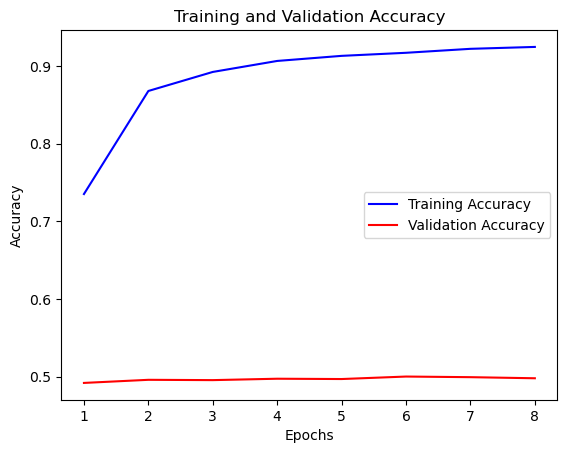

In [43]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

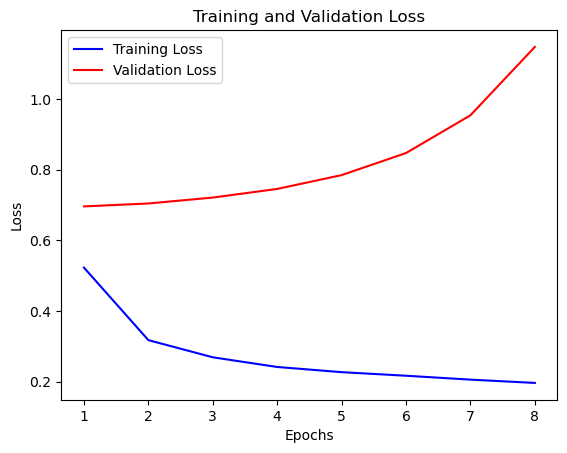

In [44]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [45]:
# num_words=7500,max_len=100, optimizer=adam,epochs=100,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,100,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=7500,batch_size=512)
trainer.train('m',100,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/100
40/40 [==============================] - 26s 615ms/step - loss: 0.4920 - accuracy: 0.7574 - val_loss: 0.8366 - val_accuracy: 0.5022
Epoch 2/100
40/40 [==============================] - 24s 613ms/step - loss: 0.2710 - accuracy: 0.8973 - val_loss: 3.6191 - val_accuracy: 0.5024
Epoch 3/100
40/40 [==============================] - 25s 636ms/step - loss: 0.2080 - accuracy: 0.9220 - val_loss: 3.5244 - val_accuracy: 0.5022
Epoch 4/100
40/40 [==============================] - 26s 639ms/step - loss: 0.1777 - accuracy: 0.9361 - val_loss: 1.6612 - val_accuracy: 0.4964
Epoch 5/100
40/40 [==============================] - 29s 718ms/step - loss: 0.1886 - accuracy: 0.9471 - val_loss: 11.0647 - val_accuracy: 0.4978
Epoch 6/100
40/40 [==============================] - 29s 721ms/step - loss: 0.1515 - accuracy: 0.9574 - val_loss: 7.6550 - val_accuracy: 0.4964
Epoch 7/100
40/40 [==============================] - 28s 695ms/step - loss: 0.1807 - accuracy: 0.9568 - val_loss: 15.6834 - val_accurac

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_100_7500_100_adam_False\assets


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 384)          2880000   
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 100, 256)          164096    
                                                                 
 global_average_pooling1d_6  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_12 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 64)               

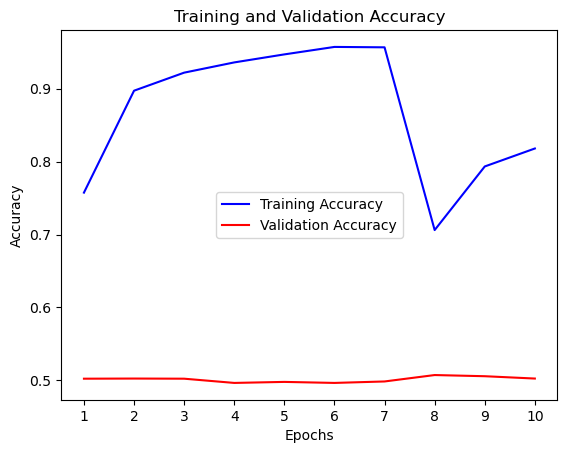

In [46]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

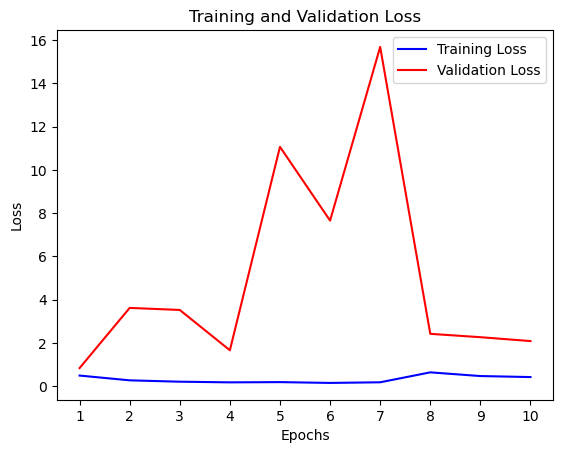

In [47]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [48]:
# num_words=7500,max_len=100, optimizer=adam,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,100,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=7500,batch_size=512)
trainer.train('m',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
40/40 [==============================] - 27s 639ms/step - loss: 0.6361 - accuracy: 0.6672 - val_loss: 0.7864 - val_accuracy: 0.4980
Epoch 2/10
40/40 [==============================] - 26s 652ms/step - loss: 0.3726 - accuracy: 0.8503 - val_loss: 1.2909 - val_accuracy: 0.4972
Epoch 3/10
40/40 [==============================] - 31s 769ms/step - loss: 0.3260 - accuracy: 0.8836 - val_loss: 1.0021 - val_accuracy: 0.4994
Epoch 4/10
40/40 [==============================] - 30s 742ms/step - loss: 0.2582 - accuracy: 0.9024 - val_loss: 3.7559 - val_accuracy: 0.5024
Epoch 5/10
40/40 [==============================] - 31s 773ms/step - loss: 0.2270 - accuracy: 0.9134 - val_loss: 1.9851 - val_accuracy: 0.5020
Epoch 6/10
40/40 [==============================] - 29s 727ms/step - loss: 0.4180 - accuracy: 0.8514 - val_loss: 4.9304 - val_accuracy: 0.5038
Epoch 7/10
40/40 [==============================] - 31s 767ms/step - loss: 0.4152 - accuracy: 0.8392 - val_loss: 5.3589 - val_accuracy: 0.4956

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_m_epochs_10_7500_100_adam_True\assets


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 384)          2880000   
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 100, 256)          164096    
                                                                 
 global_average_pooling1d_7  (None, 256)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 batch_normalization_7 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_7 (Dropout)         (None, 64)               

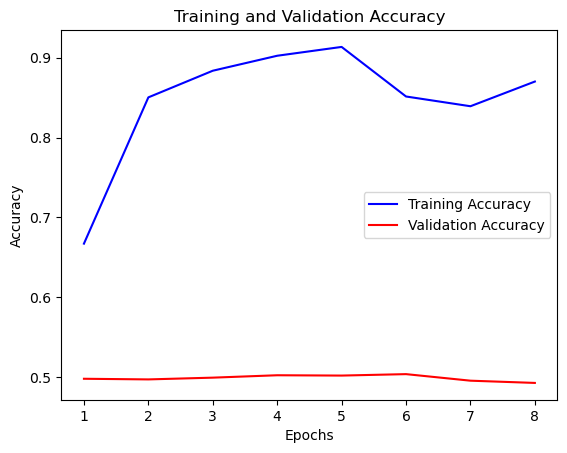

In [49]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

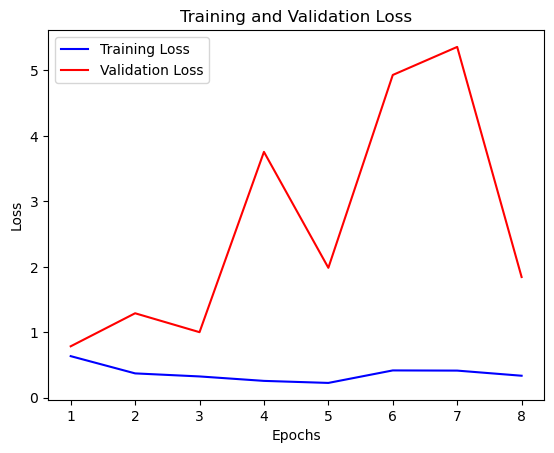

In [50]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [51]:
# Large Model

In [52]:
# num_words=10000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
                   ,num_words=10000,batch_size=512)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
40/40 [==============================] - 80s 2s/step - loss: 0.7951 - accuracy: 0.5307 - val_loss: 0.7813 - val_accuracy: 0.5052
Epoch 2/10
40/40 [==============================] - 84s 2s/step - loss: 0.6932 - accuracy: 0.6215 - val_loss: 1.0839 - val_accuracy: 0.5036
Epoch 3/10
40/40 [==============================] - 83s 2s/step - loss: 0.5456 - accuracy: 0.7299 - val_loss: 0.9342 - val_accuracy: 0.5014
Epoch 4/10
40/40 [==============================] - 82s 2s/step - loss: 0.4938 - accuracy: 0.7752 - val_loss: 1.5097 - val_accuracy: 0.5030
Epoch 5/10
40/40 [==============================] - 77s 2s/step - loss: 0.3380 - accuracy: 0.8590 - val_loss: 2.1355 - val_accuracy: 0.5034
Epoch 6/10
40/40 [==============================] - 77s 2s/step - loss: 0.3347 - accuracy: 0.8662 - val_loss: 0.7131 - val_accuracy: 0.4990
Epoch 7/10
40/40 [==============================] - 71s 2s/step - loss: 0.2613 - accuracy: 0.8899 - val_loss: 0.7286 - val_accuracy: 0.4978
Epoch 8/10
40/40 [==

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_10000_150_adam_False\assets


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 150, 768)          7680000   
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 150, 384)          442752    
                                                                 
 global_average_pooling1d_8  (None, 384)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_16 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_8 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 128)              

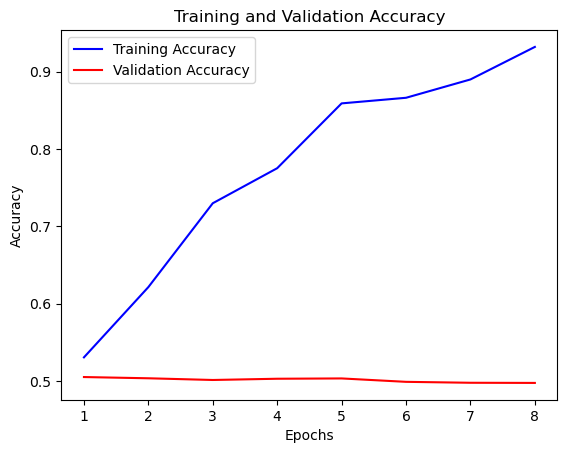

In [53]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

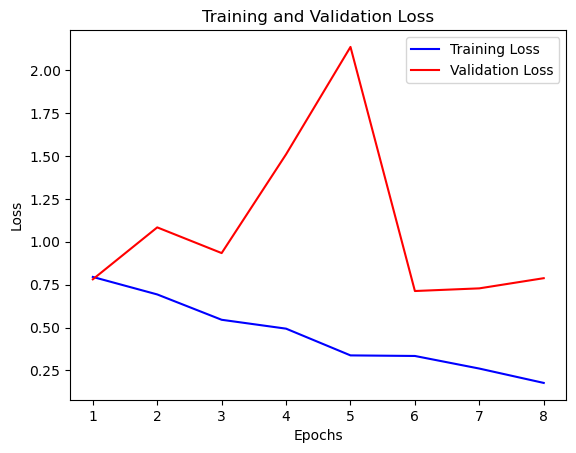

In [54]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [55]:
# num_words=10000,max_len=150, optimizer=adam,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003)
                   ,num_words=10000,batch_size=512)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
40/40 [==============================] - 77s 2s/step - loss: 0.7812 - accuracy: 0.5157 - val_loss: 1.5425 - val_accuracy: 0.5022
Epoch 2/10
40/40 [==============================] - 74s 2s/step - loss: 0.7413 - accuracy: 0.5711 - val_loss: 0.8133 - val_accuracy: 0.5002
Epoch 3/10
40/40 [==============================] - 82s 2s/step - loss: 0.5341 - accuracy: 0.7612 - val_loss: 1.5403 - val_accuracy: 0.5006
Epoch 4/10
40/40 [==============================] - 89s 2s/step - loss: 0.4276 - accuracy: 0.8142 - val_loss: 1.6519 - val_accuracy: 0.5042
Epoch 5/10
40/40 [==============================] - 89s 2s/step - loss: 0.3558 - accuracy: 0.8477 - val_loss: 2.0683 - val_accuracy: 0.5036
Epoch 6/10
40/40 [==============================] - 91s 2s/step - loss: 0.3253 - accuracy: 0.8652 - val_loss: 2.0255 - val_accuracy: 0.4950
Epoch 7/10
40/40 [==============================] - 86s 2s/step - loss: 0.3378 - accuracy: 0.8552 - val_loss: 1.4065 - val_accuracy: 0.5018
Epoch 8/10
40/40 [==

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_10000_150_adam_True\assets


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 150, 768)          7680000   
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 150, 384)          442752    
                                                                 
 global_average_pooling1d_9  (None, 384)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_18 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_9 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 128)              

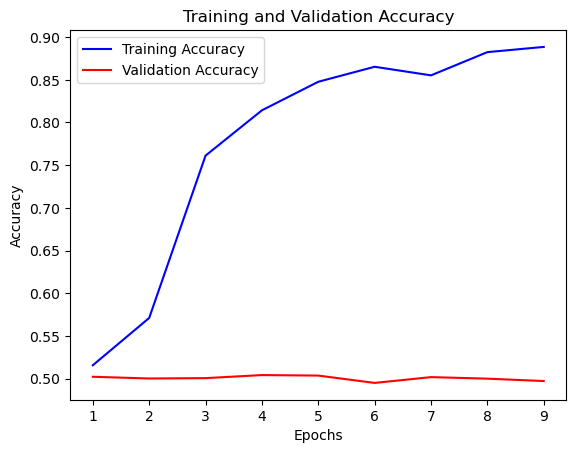

In [56]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

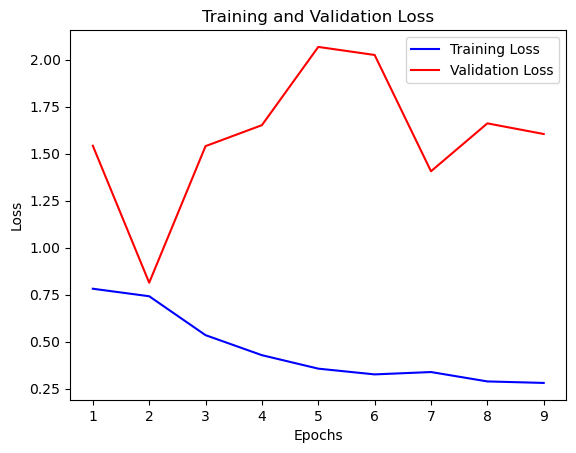

In [57]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [58]:
# num_words=20000,max_len=150, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=256)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
79/79 [==============================] - 94s 1s/step - loss: 0.8091 - accuracy: 0.5035 - val_loss: 0.7124 - val_accuracy: 0.4986
Epoch 2/10
79/79 [==============================] - 91s 1s/step - loss: 0.7260 - accuracy: 0.5343 - val_loss: 0.7435 - val_accuracy: 0.5006
Epoch 3/10
79/79 [==============================] - 87s 1s/step - loss: 0.6582 - accuracy: 0.6166 - val_loss: 0.7823 - val_accuracy: 0.4996
Epoch 4/10
79/79 [==============================] - 88s 1s/step - loss: 0.5466 - accuracy: 0.7318 - val_loss: 2.2952 - val_accuracy: 0.5060
Epoch 5/10
79/79 [==============================] - 90s 1s/step - loss: 0.5702 - accuracy: 0.7006 - val_loss: 0.7053 - val_accuracy: 0.5078
Epoch 6/10
79/79 [==============================] - 85s 1s/step - loss: 0.6070 - accuracy: 0.6647 - val_loss: 1.0123 - val_accuracy: 0.4990
Epoch 7/10
79/79 [==============================] - 85s 1s/step - loss: 0.7049 - accuracy: 0.5643 - val_loss: 0.7677 - val_accuracy: 0.4942
Epoch 8/10
79/79 [==

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_150_adam_False\assets


Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_10 (Embedding)    (None, 150, 768)          15360000  
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 150, 384)          442752    
                                                                 
 global_average_pooling1d_1  (None, 384)               0         
 0 (GlobalAveragePooling1D)                                      
                                                                 
 dense_20 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_10 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_10 (Dropout)        (None, 128)             

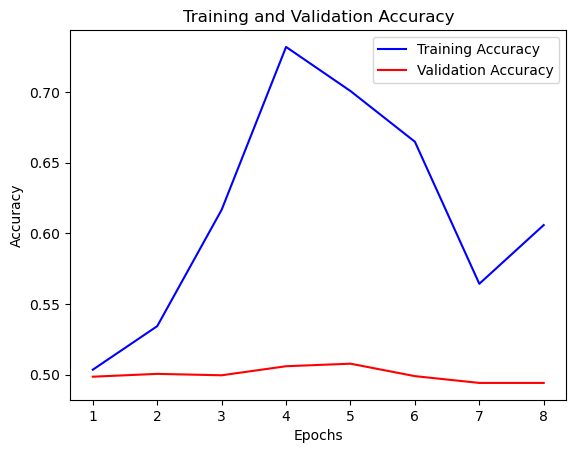

In [59]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

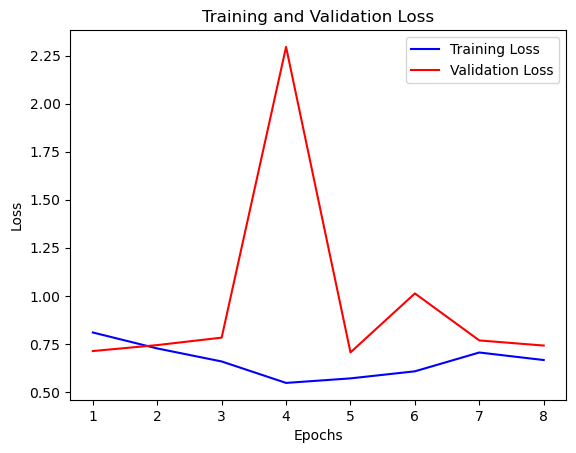

In [60]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [61]:
# num_words=20000,max_len=150, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,150,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=256)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
79/79 [==============================] - 88s 1s/step - loss: 0.4712 - accuracy: 0.7726 - val_loss: 0.7018 - val_accuracy: 0.5000
Epoch 2/10
79/79 [==============================] - 94s 1s/step - loss: 0.2108 - accuracy: 0.9159 - val_loss: 0.7424 - val_accuracy: 0.4972
Epoch 3/10
79/79 [==============================] - 96s 1s/step - loss: 0.1089 - accuracy: 0.9620 - val_loss: 0.9125 - val_accuracy: 0.4930
Epoch 4/10
79/79 [==============================] - 162s 2s/step - loss: 0.0591 - accuracy: 0.9801 - val_loss: 1.5884 - val_accuracy: 0.4990
Epoch 5/10
79/79 [==============================] - 164s 2s/step - loss: 0.0443 - accuracy: 0.9854 - val_loss: 2.0671 - val_accuracy: 0.4954
Epoch 6/10
79/79 [==============================] - 160s 2s/step - loss: 0.0528 - accuracy: 0.9808 - val_loss: 2.6540 - val_accuracy: 0.4944
Epoch 7/10
79/79 [==============================] - 146s 2s/step - loss: 0.0638 - accuracy: 0.9757 - val_loss: 3.4783 - val_accuracy: 0.4944
Epoch 8/10
79/79

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_150_adam_True\assets


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_11 (Embedding)    (None, 150, 768)          15360000  
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 150, 384)          442752    
                                                                 
 global_average_pooling1d_1  (None, 384)               0         
 1 (GlobalAveragePooling1D)                                      
                                                                 
 dense_22 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_11 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_11 (Dropout)        (None, 128)             

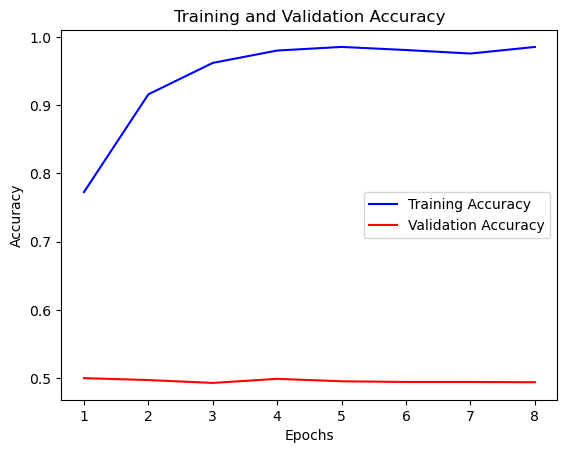

In [62]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

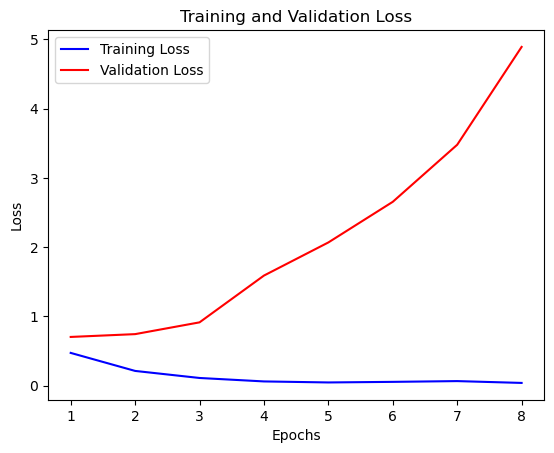

In [63]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [64]:
# num_words=20000,max_len=200, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,200,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=128)
trainer.train('l',10,False)# On clean Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
157/157 [==============================] - 247s 2s/step - loss: 0.7144 - accuracy: 0.5791 - val_loss: 1.6127 - val_accuracy: 0.5018
Epoch 2/10
157/157 [==============================] - 245s 2s/step - loss: 0.6951 - accuracy: 0.5885 - val_loss: 0.6977 - val_accuracy: 0.5054
Epoch 3/10
157/157 [==============================] - 252s 2s/step - loss: 0.6763 - accuracy: 0.5923 - val_loss: 0.7178 - val_accuracy: 0.5100
Epoch 4/10
157/157 [==============================] - 252s 2s/step - loss: 0.6598 - accuracy: 0.6212 - val_loss: 0.6996 - val_accuracy: 0.5128
Epoch 5/10
157/157 [==============================] - 257s 2s/step - loss: 0.6438 - accuracy: 0.6311 - val_loss: 0.7535 - val_accuracy: 0.5092
Epoch 6/10
157/157 [==============================] - 255s 2s/step - loss: 0.6352 - accuracy: 0.6407 - val_loss: 0.8947 - val_accuracy: 0.5130
Epoch 7/10
157/157 [==============================] - 256s 2s/step - loss: 0.5855 - accuracy: 0.6888 - val_loss: 0.7515 - val_accuracy: 0.4870

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_200_adam_False\assets


Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 200, 768)          15360000  
                                                                 
 simple_rnn_12 (SimpleRNN)   (None, 200, 384)          442752    
                                                                 
 global_average_pooling1d_1  (None, 384)               0         
 2 (GlobalAveragePooling1D)                                      
                                                                 
 dense_24 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_12 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_12 (Dropout)        (None, 128)             

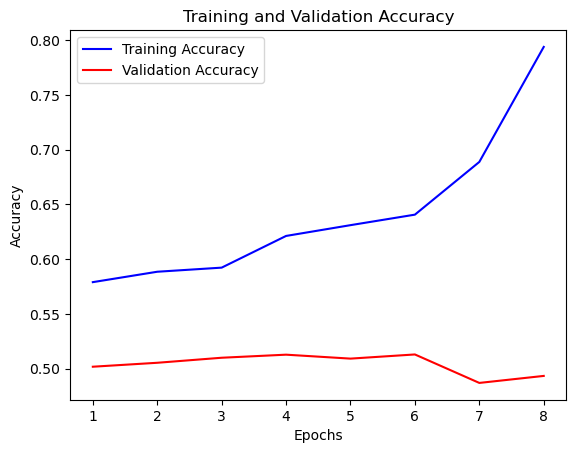

In [65]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

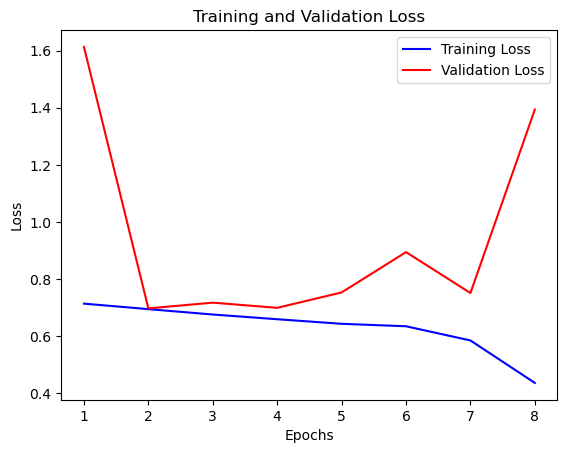

In [66]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [67]:
# num_words=20000,max_len=200, optimizer=adam, learing rate=0.03,epochs=10,batch_size=512
trainer=custom_RNN(train_df,test_df,Tokenizer,200,tf.keras.optimizers.legacy.Adam(learning_rate=0.003),
                   num_words=20000,batch_size=128)
trainer.train('l',10,True)# On raw Data
trainer.model.summary()
trainer.evaluate()

Epoch 1/10
157/157 [==============================] - 274s 2s/step - loss: 0.4461 - accuracy: 0.7879 - val_loss: 0.7032 - val_accuracy: 0.5028
Epoch 2/10
157/157 [==============================] - 270s 2s/step - loss: 0.2219 - accuracy: 0.9122 - val_loss: 0.7971 - val_accuracy: 0.5008
Epoch 3/10
157/157 [==============================] - 261s 2s/step - loss: 0.1061 - accuracy: 0.9638 - val_loss: 1.4510 - val_accuracy: 0.5036
Epoch 4/10
157/157 [==============================] - 153s 972ms/step - loss: 0.0782 - accuracy: 0.9751 - val_loss: 3.0795 - val_accuracy: 0.5038
Epoch 5/10
157/157 [==============================] - 144s 918ms/step - loss: 0.2905 - accuracy: 0.8801 - val_loss: 1.2402 - val_accuracy: 0.5056
Epoch 6/10
157/157 [==============================] - 146s 929ms/step - loss: 0.1992 - accuracy: 0.9170 - val_loss: 2.2061 - val_accuracy: 0.5038
Epoch 7/10
157/157 [==============================] - 150s 953ms/step - loss: 0.1494 - accuracy: 0.9408 - val_loss: 2.8530 - val_accu

INFO:tensorflow:Assets written to: data/LSTM_models/model_type_l_epochs_10_20000_200_adam_True\assets


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_13 (Embedding)    (None, 200, 768)          15360000  
                                                                 
 simple_rnn_13 (SimpleRNN)   (None, 200, 384)          442752    
                                                                 
 global_average_pooling1d_1  (None, 384)               0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dense_26 (Dense)            (None, 128)               49280     
                                                                 
 batch_normalization_13 (Ba  (None, 128)               512       
 tchNormalization)                                               
                                                                 
 dropout_13 (Dropout)        (None, 128)             

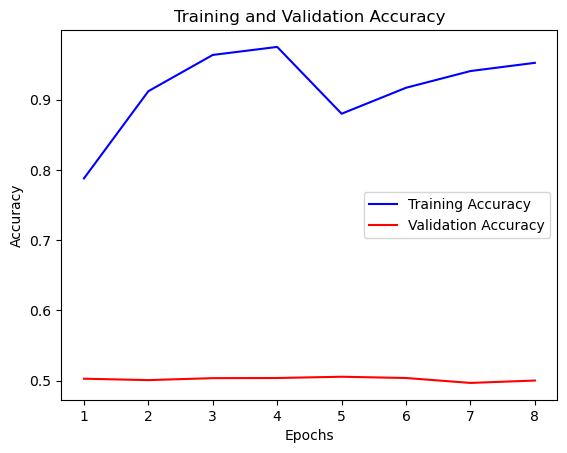

In [68]:
epochs = range(1, len(trainer.training_accuracy) + 1)
plt.plot(epochs, trainer.training_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, trainer.validation_accuracy, 'r', label='Validation Accuracy')
plt.xticks(epochs)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

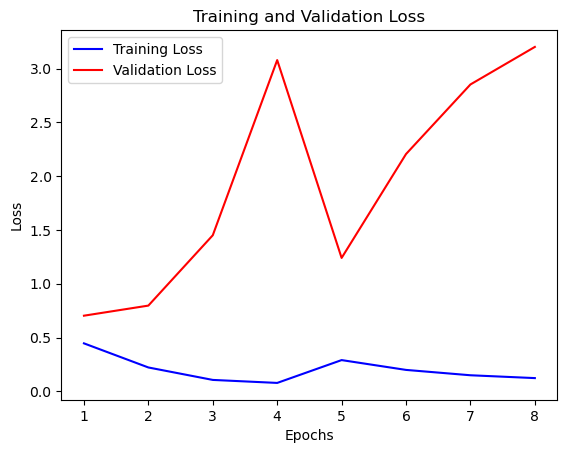

In [69]:
epochs = range(1, len(trainer.training_loss) + 1)
plt.plot(epochs, trainer.training_loss, 'b', label='Training Loss')
plt.plot(epochs, trainer.validation_loss, 'r', label='Validation Loss')
plt.xticks(epochs)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Best Accuracy : 0.83188

## Rough Work

In [70]:
# Tokenization and padding
texts = train_df['clean_text'].tolist()
tokenizer = Tokenizer(num_words=7500, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = np.array(pad_sequences(sequences, maxlen=100, padding='post', truncating='post'))

In [71]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=20000, output_dim=16, input_length=100),
    tf.keras.layers.SimpleRNN(8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [72]:
labels=np.array(train_df['sentiment'].map({'pos':1,'neg':0}).tolist())

In [73]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [74]:
model.fit(padded_sequences, labels, epochs=10)

Epoch 1/10
782/782 [==============================] - 12s 15ms/step - loss: 0.6056 - accuracy: 0.6997
Epoch 2/10
782/782 [==============================] - 12s 15ms/step - loss: 0.6423 - accuracy: 0.6191
Epoch 3/10
782/782 [==============================] - 15s 19ms/step - loss: 0.6336 - accuracy: 0.6298
Epoch 4/10
782/782 [==============================] - 12s 15ms/step - loss: 0.5926 - accuracy: 0.6782
Epoch 5/10
782/782 [==============================] - 12s 15ms/step - loss: 0.4611 - accuracy: 0.7938
Epoch 6/10
782/782 [==============================] - 13s 17ms/step - loss: 0.3567 - accuracy: 0.8589
Epoch 7/10
782/782 [==============================] - 13s 17ms/step - loss: 0.2920 - accuracy: 0.8900
Epoch 8/10
782/782 [==============================] - 12s 15ms/step - loss: 0.2504 - accuracy: 0.9060
Epoch 9/10
782/782 [==============================] - 11s 15ms/step - loss: 0.2545 - accuracy: 0.8970
Epoch 10/10
782/782 [==============================] - 12s 16ms/step - loss: 0.219

In [75]:
test_df.head()

,Unnamed: 0,rec_id,text,sentiment,rating,clean_text
0,0,4715,"Based on an actual story, John Boorman shows t...",pos,9,base actual story john footman show struggle a...
1,1,1930,This is a gem. As a Film Four production - the...,pos,9,gem film production anticipated quality indeed...
2,2,3205,"I really like this show. It has drama, romance...",pos,9,really like show drama romance comedy roll one...
3,3,10186,This is the best 3-D experience Disney has at ...,pos,10,best experience kidney themeparks certainly go...
4,4,147,"Of the Korean movies I've seen, only three had...",pos,10,organ move see three really stick first excell...


In [76]:
new_texts= test_df['clean_text'].tolist()
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded_sequences = np.array(pad_sequences(new_sequences, maxlen=100, padding='post', truncating='post'))
y_test=np.array(test_df['sentiment'].map({'pos':1,'neg':0}).tolist())
predictions = model.predict(new_padded_sequences)
binary_predictions = [1 if pred > 0.5 else 0 for pred in predictions]


782/782 [==============================] - 3s 4ms/step


In [77]:
accuracy_rnn = accuracy_score(y_test, binary_predictions)

In [78]:
print("Accuracy (RNN):", accuracy_rnn)

Accuracy (RNN): 0.6734
